# Multiregion Windpower Model

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel


%load_ext autoreload
%autoreload 2
%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Modelsetup

This notebook explains the MultiRegionWindForecastModel class to model the wind in different regions (e.g. for the pricing of greeen PPA). 

For this we assume that we have given $n$ artificial regions...


Let us denote by $q_i(t,T)$ the wind forecast at time $t$ for future time $T$  in region $i$ (as  percentage of maximal capacity for this region) by
$$
q_i(t,T) = E\left[f\left(f^{-1}(q_i(0,T)) + X^i_T-X_0^i\right)\mid X^i_t\right]
$$
where $f$ is an invertible sigmoid function such as the logistic or smoothstep function and $X_t$ a stochastic process. We define $\phi^i(T):= f^{-1}(q_i(0,T))-X^i_0$ and get
$$
q_i(t,T) = E\left[f\left(\phi^i(T) + X^i_T\right)\mid X^i_t\right]
$$

In [2]:
# setup 
wind_region_model = {}
vols = [1.0,3.0,6.0]
mean_reversion_speed = [0.5,2.0,6.0]
capacities = [10_000.0, 120_000.0, 75_000.0]
rnd_weights = [ [0.8,0.2],
               [0.8,0.2],
               [0.8,0.2]
              ]
np.random.seed(42)
regions = []
for i in range(len(vols)):
    model = WindPowerForecastModel(region='Region_' + str(i), 
                                            speed_of_mean_reversion=mean_reversion_speed[i],
                                            volatility=vols[i])
    regions.append(MultiRegionWindForecastModel.Region( 
                                    model,
                                    capacity=capacities[i],
                                    rnd_weights=rnd_weights[i]
                                ) )
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

After setting up three regions we just simulate the weather forecast over the next ten days for the following four hours.

In [3]:
n_sims = 10_000
days = 10 # number of days
timegrid = np.linspace(0.0, days*1.0/365.0, days*24) # simulation time grid
forward_expiries = [timegrid[-1] + i/(365.0*24.0) for i in range(4)] # time points for the forwards
rnd = np.random.normal(size=wind.rnd_shape(n_sims, timegrid.shape[0]))
results = wind.simulate(timegrid, rnd, expiries=forward_expiries, 
                                       initial_forecasts={'Region_0': [0.7, 0.7,0.6,0.5],
                                                          'Region_1': [0.75, 0.6, 0.5, 0.5],
                                                         'Region_2': [0.8, 0.6, 0.5, 0.5]} # initial forecast values for the repsective 4 hours 
                               )

In [4]:
# We get the To obtain the respective simulations we 
results.keys()

{'Region_0_FWD0',
 'Region_0_FWD1',
 'Region_0_FWD2',
 'Region_0_FWD3',
 'Region_1_FWD0',
 'Region_1_FWD1',
 'Region_1_FWD2',
 'Region_1_FWD3',
 'Region_2_FWD0',
 'Region_2_FWD1',
 'Region_2_FWD2',
 'Region_2_FWD3',
 'Wind_Germany_FWD0',
 'Wind_Germany_FWD1',
 'Wind_Germany_FWD2',
 'Wind_Germany_FWD3'}

## Path Simulation

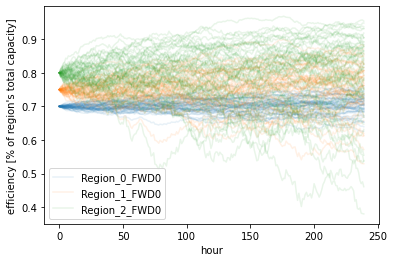

In [5]:
plt.figure()
for k in results.keys():
    if ('Region' in k) and ('FWD0' in k):
        tmp = results.get(k)
        label = k
        p = plt.plot(tmp[:,0],alpha=0.1, label=label)
        for j in range(1,50):
            label = None
            plt.plot(tmp[:,j],color = p[0].get_color(), alpha=0.1, label=label)
plt.legend()
plt.xlabel('hour')
plt.ylabel("efficiency [% of region's total capacity]");

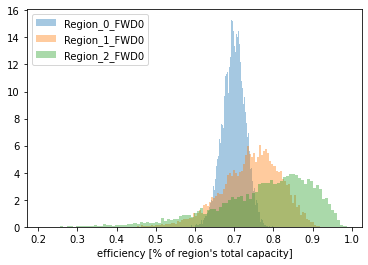

In [6]:
plt.figure()
for k in results.keys():
    if ('Region' in k) and ('FWD0' in k):
        tmp = results.get(k)
        plt.hist(tmp[-1,:],bins = 100, alpha=0.4, label=k, density = True)
plt.legend()
#plt.xlabel('hour')
plt.xlabel("efficiency [% of region's total capacity]");

In [27]:
from scipy.interpolate import Rbf
np.random.seed(42)
np.choice(map_df)

3890000

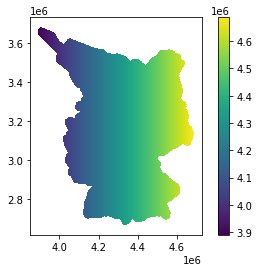

In [25]:
import geopandas

fp = "/home/doeltz/doeltz/development/map_de/de_1km.shp"
map_df = geopandas.read_file(fp)

map_df.plot('EOFORIGIN', legend=True);#, figsize=(12,8));

plt.savefig('depp.png',dpi=1500)

In [22]:
?map_df.plot

# Residual Demand Forward Model

In [45]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.01, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rd_model = ResidualDemandForwardModel(wind_power_forecast=wind, highest_price_ou_model= highest_price, 
                                      supply_curve=supply_curve, max_price=1.0, power_name= 'Power_Germany')

In [46]:
rnd = np.random.normal(size=rd_model.rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))

In [47]:
rdm_result = rd_model.simulate(timegrid, rnd, expiries=forward_expiries, initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                          'Offshore': [0.6,0.6,0.6,0.6]})

In [11]:
rdm_result.get('Power_Germany:0', forecast_timepoints=[0,1,2])

array([[0.26666667, 0.26666667, 0.26666667, ..., 0.26666667, 0.26666667,
        0.26666667],
       [0.26021478, 0.27070423, 0.26975393, ..., 0.26509957, 0.26823855,
        0.26438372],
       [0.25406328, 0.27815923, 0.27138286, ..., 0.26864876, 0.26813227,
        0.27003154],
       ...,
       [0.28389246, 0.29749926, 0.24491791, ..., 0.28798642, 0.24734741,
        0.23657972],
       [0.28392222, 0.29742968, 0.24492363, ..., 0.28800452, 0.24734926,
        0.23654951],
       [0.28392685, 0.29743316, 0.24492425, ..., 0.28804524, 0.24733697,
        0.23655771]])

In [12]:
rd_model.udls()

{'Offshore', 'Onshore', 'Power_Germany', 'Wind_Germany'}

# PPA Hedging

In [19]:
results = {}
with open('hedge_results.json','r') as f:
    results = json.load(f)
from rivapy.tools.interfaces import FactoryObject

def compute_pnl_figures(pricing_results):
    pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)
    return {'mean': pnl.mean, 'var': pnl.var, '1%':np.percentile(pnl,) '99%'}
def run_hedge_experiment(val_date, ppa_spec, model, **kwargs):
    params = {}
    params['ppa_spec'] = ppa_spec.to_dict()
    params['ppa_spec_hash'] = ppa_spec.hash()
    params['model'] = model.to_dict()
    params['model_hash'] = model.hash()
    params['pricing_param'] = kwargs
    hash_key = FactoryObject.hash_for_dict(params)
    #if hash_key in results:
        
    pricing_result =  GreenPPADeepHedgingPricer.price(val_date, 
                                  ppa_spec, 
                                  model,**kwargs)
    

In [2]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)
highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.01, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rd_model = ResidualDemandForwardModel(wind_power_forecast=wind, highest_price_ou_model= highest_price, 
                                      supply_curve=supply_curve, max_price=1.0, power_name= 'Power_Germany')

In [3]:
val_date = dt.datetime(2023,1,1)
strike = 0.3 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [6]:
pricing_results.hedge_model.save('depp')

INFO:tensorflow:Assets written to: depp/delta_model\assets


INFO:tensorflow:Assets written to: depp/delta_model\assets


In [11]:
model = DeepHedgeModel.load('depp')

In [20]:
pricing_results = run_hedge_experiment(val_date, 
                                      spec, 
                                      rd_model, 
                                        initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                            'Offshore': [0.6,0.6,0.6,0.6]},
                                        forecast_hours=[10, 14, 18],
                                        additional_states=['Offshore'],
                                          depth=3, nb_neurons=32, n_sims=10_000, 
                                        regularization=0.0,
                                          epochs=200, verbose=1,
                                        tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                        initial_lr=5e-4,
                                        decay_steps=8_000,
                                          batch_size=100, decay_rate=0.8, seed=42)

4568d6a64044c5ca102f46bdc0f3b8a7400d5607


C:\Users\doeltz\development\RiVaPy\notebooks\models\../..\rivapy\tools\datetime_grid.py:24: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  self.dates = pd.date_range(start, end, freq=freq, tz=tz, closed=closed).to_pydatetime()


Epoch 1/200


KeyboardInterrupt: 

In [39]:
pricing_results.paths.keys()
#ttm

dict_keys(['Power_Germany_FWD0', 'Onshore_FWD0', 'Offshore_FWD0'])

8/8 [==============================] - 0s 1ms/step


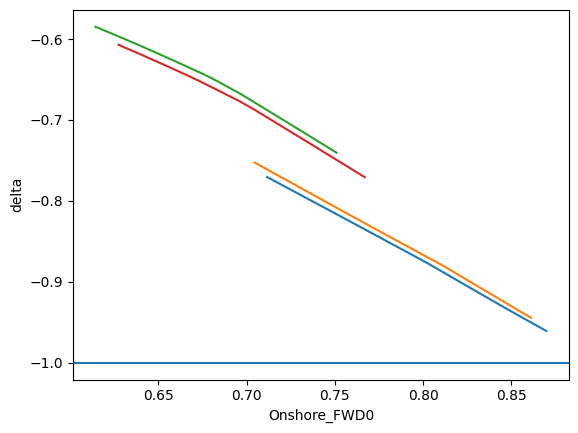

In [85]:
t = 48
p=10.0
projection = np.linspace(0.9,1.1, 250)
projected_key = 'Onshore_FWD0'
for selected in [2,5,100,400]:
#selected = 2
    #key = 'Power_Germany_FWD0'
    #x = np.percentile(pricing_results.paths[key][-1,:],p)
    #selected = np.abs(x-pricing_results.paths[key][-1,:]).argmin()
    paths = {}

    T = pricing_results.hedge_model.timegrid[-1]
    ttm = (T-pricing_results.hedge_model.timegrid[t])/T
    for k,v in pricing_results.paths.items():
        if k == projected_key:
            paths[k] = projection*v[t,selected]
            x = projection*v[t,selected]
        else:
            paths[k] = np.full(shape=(projection.shape[0]), fill_value=v[t,selected])
    delta = pricing_results.hedge_model.compute_delta(paths, ttm)   

    plt.plot(x, delta)
plt.xlabel(projected_key)
plt.axhline(-1.0)
plt.ylabel('delta');

## Path Plots

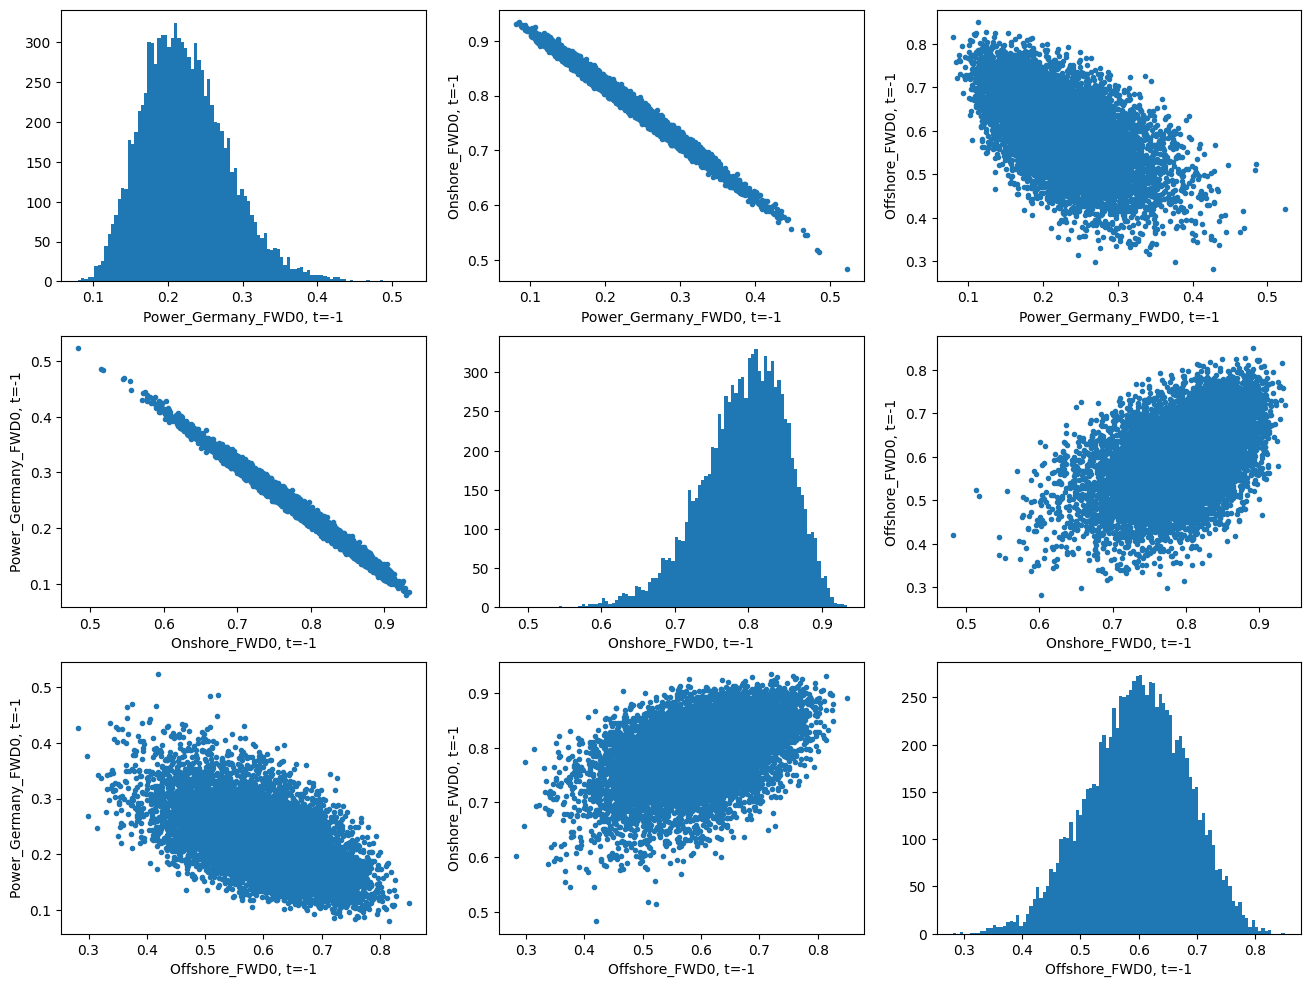

In [67]:
t = -1
plt.figure(figsize=(16,12))
n_x = 3
n_y = 3
i=1
for k,v in pricing_results.paths.items():
    for l,w in pricing_results.paths.items():
        plt.subplot(n_x,n_y,i)
        if k==l:
            plt.hist(v[t,:], bins=100)
            plt.xlabel(k+', t='+str(t))
        else:
            plt.plot(v[t,:], w[t,:], '.')
            plt.xlabel(k+', t='+str(t))
            plt.ylabel(l+', t='+str(t))
        i += 1

## Hedge PnL Distribution

313/313 [==============================] - 8s 4ms/step


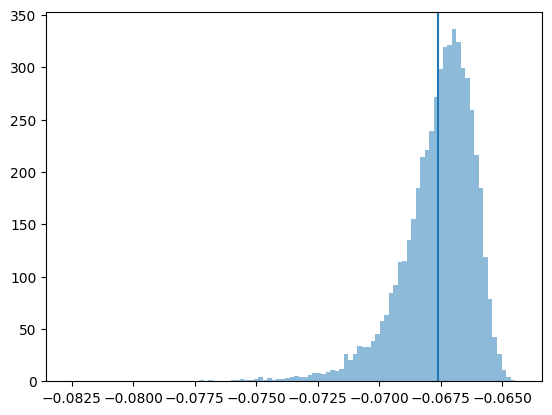

In [12]:
pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)

#plt.hist(pricing_results.payoff, bins=100, alpha=0.5, density=True)
plt.axvline(pnl.mean())
plt.hist(pnl,bins=100, alpha=0.5, density=True);

## Delta Plots

313/313 [==============================] - 1s 2ms/step


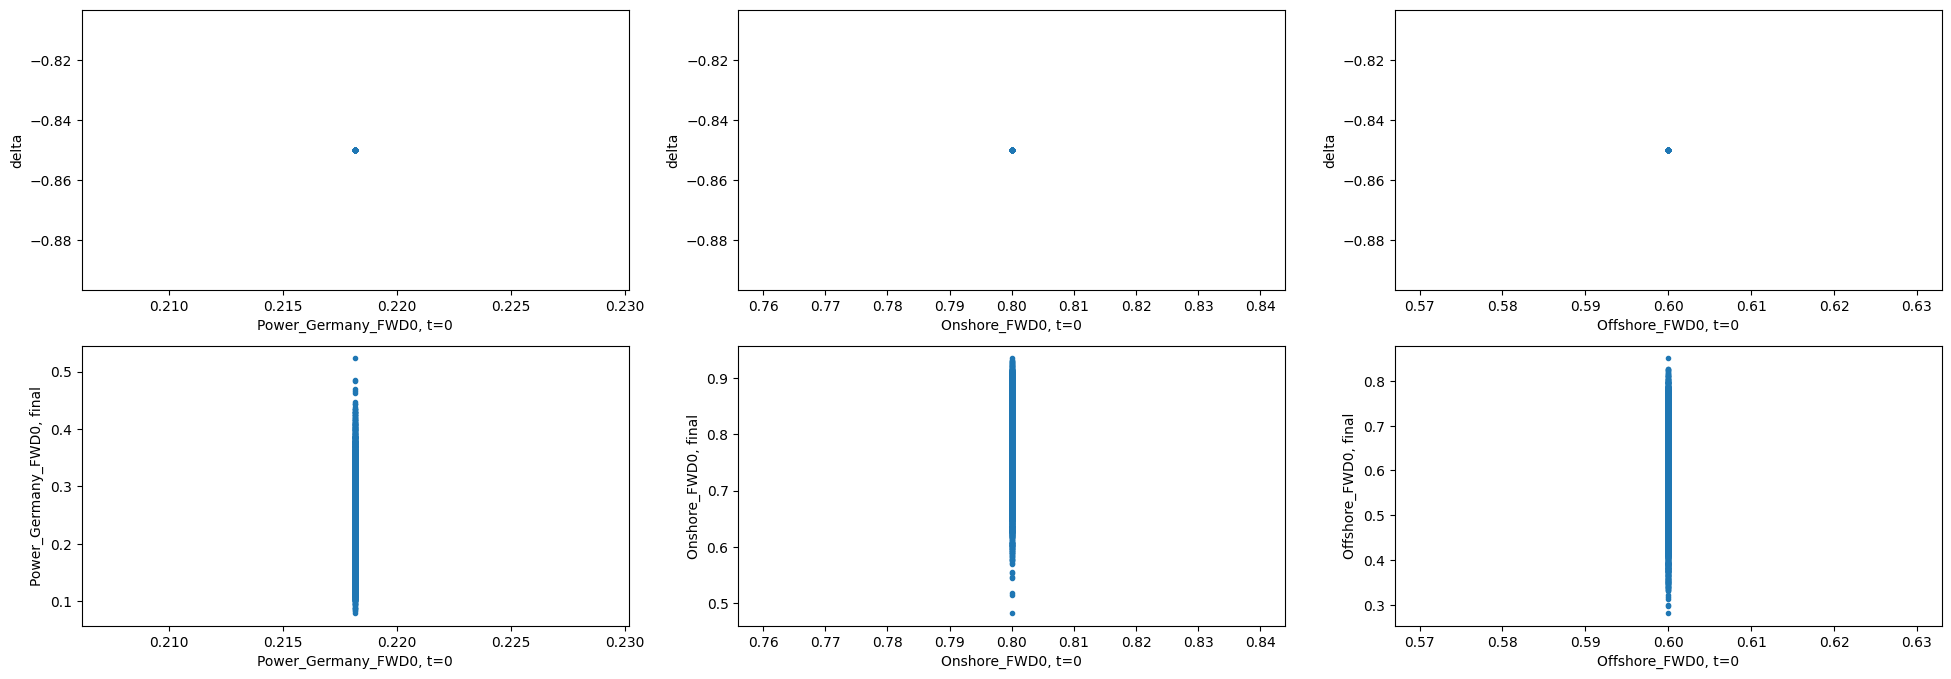

In [64]:
t = 0
n_x = 2
n_y = 3
plt.figure(figsize=(24,8))
delta = pricing_results.hedge_model.compute_delta(pricing_results.paths, t)
i=1
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], delta,'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel('delta')
    i+= 1
    
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], v[-1,:],'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel(k+', final')
    i+= 1